Trying to learn how to use PyCUDA...

Gonna start off with comparing serial vs parallelized mandelbrot.

In [1]:
# Used example code online to just get the libraries working, Windows PATH variables are annoying...

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy
a = numpy.random.randn(4,4)
a = a.astype(numpy.float32)
a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)
mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)
func = mod.get_function("doublify")
func(a_gpu, block=(4,4,1))
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)
print(a_doubled)
print(a)

[[ 4.848793   -2.6476     -1.5264568  -0.10156377]
 [ 0.5865882  -2.953162   -1.299474   -0.509429  ]
 [-4.7461023   0.30381018  0.5141573   1.120237  ]
 [ 1.6288046  -2.4609551   1.1326913   0.6512581 ]]
[[ 2.4243965  -1.3238     -0.7632284  -0.05078189]
 [ 0.2932941  -1.476581   -0.649737   -0.2547145 ]
 [-2.3730512   0.15190509  0.25707865  0.5601185 ]
 [ 0.8144023  -1.2304776   0.56634563  0.32562906]]


In [15]:
# Serial Mandelbrot
# Porting https://github.com/cmu15418/assignment1/blob/master/prog1_mandelbrot_threads/mandelbrotSerial.cpp
# which is a slightly modified example provided by intel
import numpy
from numba import jit

@jit
def mandel_jit(c_re, c_im, count):
    z_re = c_re
    z_im = c_im
    i = 0
    while i < count:
        if z_re**2 + z_im**2 > 4.0:
            break
        
        new_re = z_re**2 - z_im**2
        new_im = 2.0 * z_re * z_im
        z_re = c_re + new_re
        z_im = c_im + new_im
        i += 1
    return i

@jit
def mandel_serial_jit(x0, y0, x1, y1, width, height, maxIters):
    dx = (x1 - x0)/width
    dy = (y1 - y0)/height
    output = numpy.empty((width, height))
    x_range = [None] * width
    y_range = [None] * height
    for i in range(0, width):
        x_range[i] = x0 + i * dx
    for i in range(0, height):
        y_range[i] = y0 + i * dy
    
    for j in range(0, width):
        for i in range(0, height):
            # Not actually sure what's faster, accessing the array or doing this operation
            x = x0 + i * dx
            y = y0 + j * dy
            output[i, j] = mandel_jit(x, y, maxIters)
    return x_range, y_range, output

def mandel(c_re, c_im, count):
    z_re = c_re
    z_im = c_im
    i = 0
    while i < count:
        if z_re**2 + z_im**2 > 4.0:
            break
        
        new_re = z_re**2 - z_im**2
        new_im = 2.0 * z_re * z_im
        z_re = c_re + new_re
        z_im = c_im + new_im
        i += 1
    return i

def mandel_serial(x0, y0, x1, y1, width, height, maxIters):
    dx = (x1 - x0)/width
    dy = (y1 - y0)/height
    output = numpy.empty((width, height))
    x_range = [None] * width
    y_range = [None] * height
    for i in range(0, width):
        x_range[i] = x0 + i * dx
    for i in range(0, height):
        y_range[i] = y0 + i * dy
    
    for j in range(0, width):
        for i in range(0, height):
            # Not actually sure what's faster, accessing the array or doing this operation
            x = x0 + i * dx
            y = y0 + j * dy
            output[i, j] = mandel(x, y, maxIters)
    return x_range, y_range, output

I just learned of jit (Just in Time Compiler) and I'm kind of digging it, it makes python runtime SUPER fast :o
Apparently it converts Python code into very optimized machine code.

In [16]:
%timeit -n 1
%timeit mandel_serial(-2.0,-1.25,0.5,1.25,1000,1000,80)
%timeit mandel_serial_jit(-2.0,-1.25,0.5,1.25,1000,1000,80)

21.4 s ± 514 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
95 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# Stealing someone's code on how to display
# Using this to verify that my code is actually working
# https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

def mandel_image(x0,y0,x1,y1,width=10,height=10,maxiter=256):
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    x,y,z = mandel_serial(x0,y0,x1,y1,img_width,img_height,maxiter)
    fig, ax = plt.subplots(figsize=(width, height),dpi=72)
    ticks = numpy.arange(0,img_width,3*dpi)
    x_ticks = x0 + (x1-x0)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = y0 + (y1-y0)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    ax.imshow(z.T,origin='lower') 

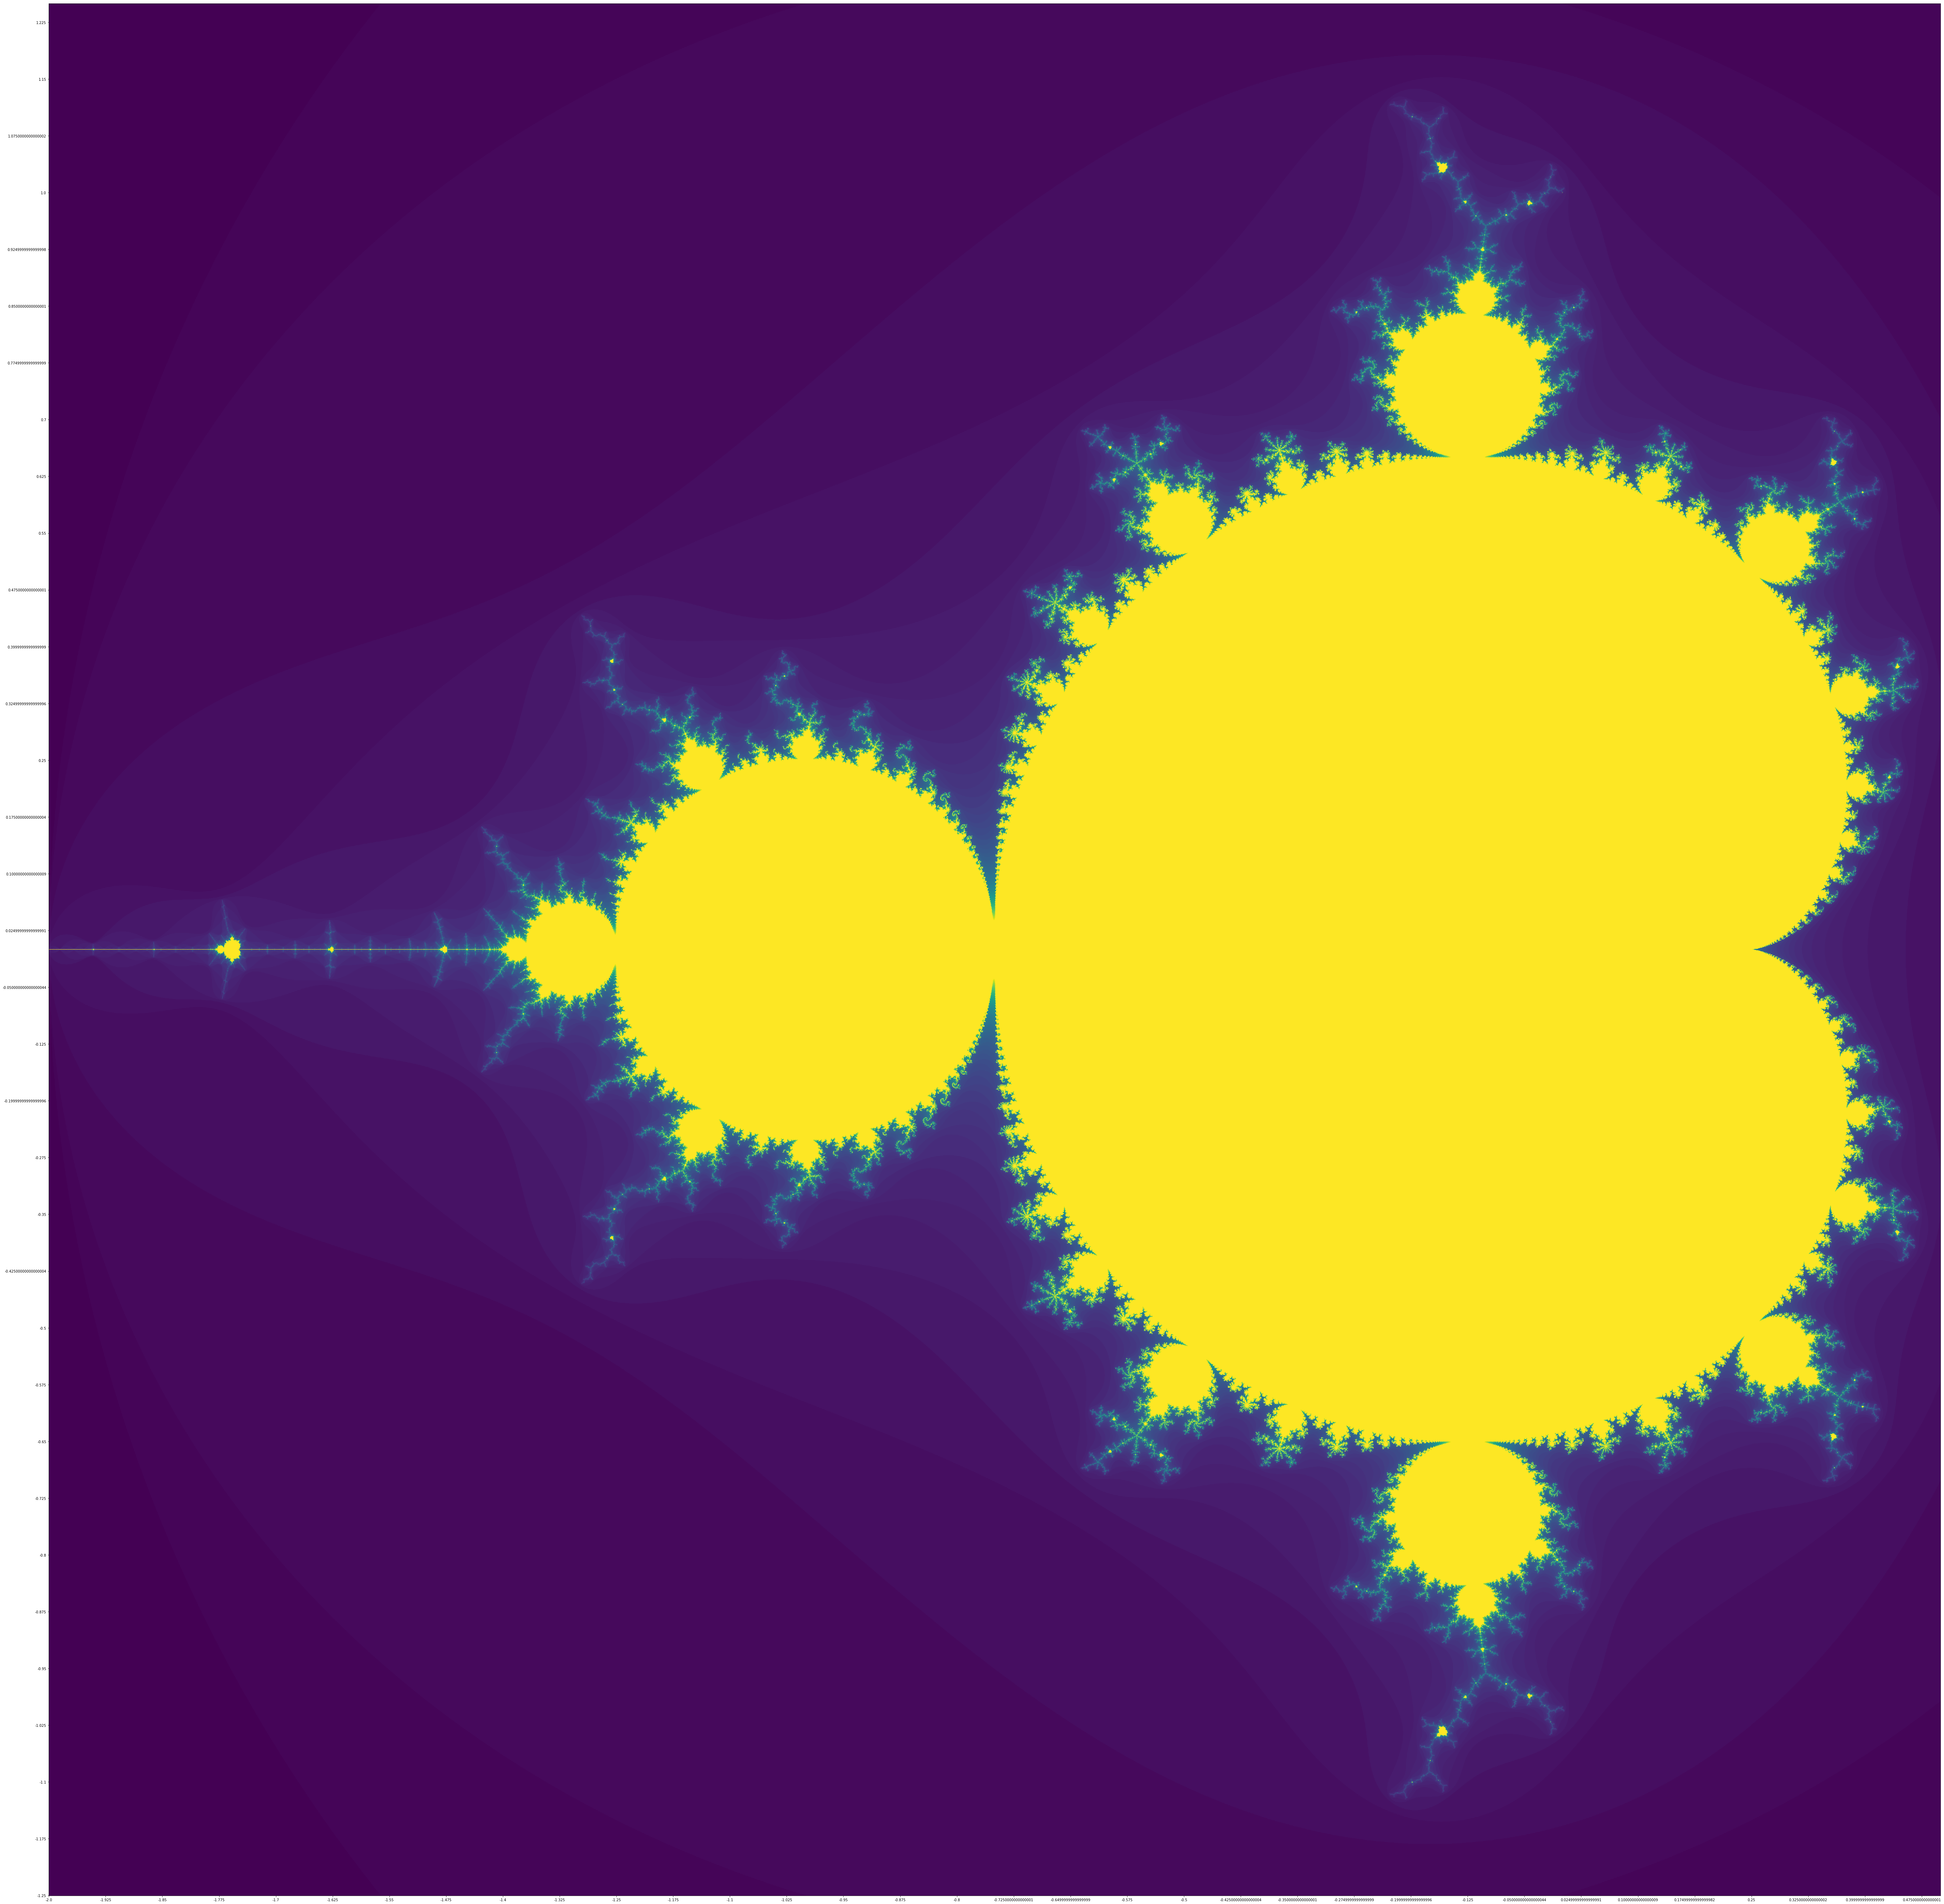

In [14]:
mandel_image(-2.0,-1.25,0.5,1.25,100,100,80)

In [ ]:
# Time to see if we can replicate this on my GPU
# Don't think we need any device functions....

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy

def mandel_gpu(x0, y0, x1, y1, width, height, maxIters):
    output = numpy.zeros(width,height)
    output = output.astype(numpy.float32)
    dx = (x1 - x0)/width
    dy = (y1 - y0)/height
    x_range = [None] * width
    y_range = [None] * height
    for i in range(0, width):
        x_range[i] = x0 + i * dx
    for i in range(0, height):
        y_range[i] = y0 + i * dy
    gpu = cuda.mem_alloc(output.nbytes + )
    cuda.memcpy_htod(gpu, output)
    mod = SourceModule("""
        __global__ void mandelGpu(float *c_re, float *c_im, int *a, int maxIter)
        {
            int idx = threadIdx.x + threadIdx.y*4;
            a[idx] *= 2;
        }
        """)
    func = mod.get_function("mandelGpu")
    